In [21]:
import sys
import os
import ee
import geemap
import rasterio
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'Enschede_Farmland.tif')
filename_corine = os.path.join(out_dir, 'Enschede_Farmland_Corine.tif')

try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise


Google Earth Engine has initialized successfully!


In [61]:
#define region to look at
region = ee.Geometry.Polygon(
[[[6.641434, 52.091838],
  [6.677044, 52.091838],
  [6.677044, 52.311512],
  [6.841434, 52.311512],
  [6.841434, 52.091838]]]
)

In [32]:
start_date = '2010-01-01'
end_date = '2022-12-30'
cloud_percentage = 10

myCollection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(region) \
    .filterDate(start_date, end_date) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', cloud_percentage)

In [24]:
listOfImages = myCollection.aggregate_array('system:index').getInfo()
print('Number of images in the collection: ', len(listOfImages))


Number of images in the collection:  61


In [25]:
#use first image and clip it to the region
img1 = myCollection.first().clip(region)


In [26]:
# img1 = img1.updateMask(farmlandMask)

In [45]:
# Some visualization parameters:
# - Values to map to 0 and values to map to 255.
# - Three bands to be combined as an rgb image

# You can try changing these parameters and check the result!

vis_params = {"min": 0,
              "max": 1500,
              "bands": ["B4", "B3", "B2"]}
vis_params_corine = {"min": 0,
              "max": 1500}


In [28]:
Map2 = geemap.Map()
Map2.addLayer(img1, vis_params, "FirstImage", True)
img2 = myCollection.median().clip(region)
Map2.addLayer(img2, vis_params, "MedianImage", True)


In [10]:
# Exporting all bands as one single image
# By "file_per_band=True" you can export each band as one image
# With the "scale" parameter you can change the spatial resolution of the exported image.
# Higher spatial resolution (lower scale) leads to longer downloading time.

geemap.ee_export_image(
    img2, filename=filename, scale=15, region=region, file_per_band=False
)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\ruben\Downloads\Enschede_Farmland.tif


In [62]:
img1corine = ee.Image('COPERNICUS/CORINE/V20/100m/2018') \
                  .clip(region) \
                  .select('landcover');

# Select only the pixels that belong to the farmland classes (211 and 242)
farmlandMask = img1corine.eq(211) \
                .Or(img1corine.eq(212)) \
                .Or(img1corine.eq(213)) \
                .Or(img1corine.eq(221)) \
                .Or(img1corine.eq(222)) \
                .Or(img1corine.eq(223)) \
                .Or(img1corine.eq(231)) \
                .Or(img1corine.eq(241)) \
                .Or(img1corine.eq(242)) \
                .Or(img1corine.eq(243)) \
                .Or(img1corine.eq(244))

Map2 = geemap.Map(location=[52.191838, 6.741434], zoom=13)
Map2.addLayer(farmlandMask, {}, "FirstImage", True)
# img2 = myCollection.median().clip(region)
# Map2.addLayer(img2, vis_params, "MedianImage", True)

Map2

Map(center=[52.191838, 6.741434], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [12]:
with rasterio.open(filename, 'r') as ds:
    img = ds.read()  # read all raster values

array = np.array(img)
farmland_array = np.array(img1corine)
# Apply the farmland mask to the image using numpy
# background_value = 0 # set the background value
# img = np.where(farmlandMask, img, background_value)

img = img[0:12,:,:] # 12 spectral bands
img = np.transpose(img, [1, 2, 0]) # numpy array [row, col, bands]
print(farmland_array.shape)
print(img.shape)
type(img)

()
(147, 265, 12)


numpy.ndarray

In [13]:
# B2-->Blue
# B3-->Green
# B4-->Red

# remember the indexes in NumPy arrays start with 0 --> bands begin from 0!

img_rgb = img[:,:,[3,2,1]]
print(img_rgb.shape)


(147, 265, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


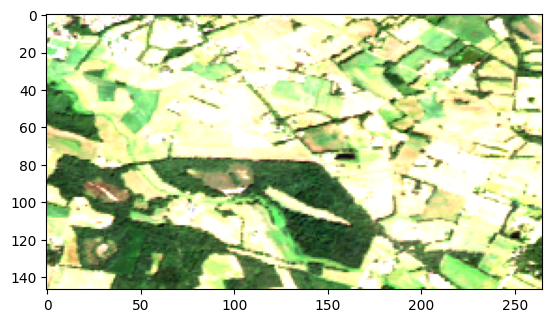

In [14]:
# This function normalizes each rgb band and helps you to have a better visualization.

def MyNormalize(img_i,sigma):
    nr,nc,nb = img_i.shape
    img_n = np.zeros(shape=(nr,nc,nb))
    for i in range(0,nb):
        one_band = img_i[:,:,i]
        mi = np.min(one_band)
        ma = np.max(one_band)
        one_band = (one_band-mi)/(ma-mi+np.finfo(float).eps)
        img_n[:,:,i] = sigma*one_band
    return img_n

plt.imshow(MyNormalize(img_rgb,5))
